# Building Recommendation System with Deep Reinforcement Learning and Neo4j

## Introduction
In this tutorial We will be building a movie recommendantion enine leveraging a blend of graph-based machine learning and deep reinforcement learning (DRL). This post details an approach using [Neo4j](https://neo4j.com) graph embeddings, generated through Node2Vec algorithm, combined with a PyTorch-based Deep Q-Network (DQN) for dynamic movie recommendations.
We will be using the [DVD Rental Database](https://www.postgresqltutorial.com/postgresql-getting-started/postgresql-sample-database/) that we have used in a couple of posts before. We showed how we can download and populate the data into Neo4j database in this previous [tutorial](https://minimatech.org/from-relational-to-neo4j/). We will also be leveraging the [Graph Data Science](https://neo4j.com/product/graph-data-science/) (GDS) library in Neo4j to get the Node2Vec embeddings. You can refer to the full code in the project's notebook in Github [here](https://github.com/MNoorFawi/building-recommendation-engine-with-reinforcement-learning).

Let's quickly try to do some imports and do quick queries on the database to make sure everything is ready. We will query the labels of nodes and types of the relationships.

In [1]:
import random
from collections import deque
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from neo4j import GraphDatabase


driver = GraphDatabase.driver("bolt://localhost:7687",
                              auth = ("neo4j", "password"))

def neo4j_run(q):
    return list(driver.session().run(q))

In [2]:
neo4j_run("match (n) return distinct labels(n);")

[<Record labels(n)=['Actor']>,
 <Record labels(n)=['Customer']>,
 <Record labels(n)=['Category']>,
 <Record labels(n)=['Film']>]

In [3]:
neo4j_run("match ()-[r]->() return distinct type(r);")

[<Record type(r)='RENTED'>,
 <Record type(r)='ACTED_IN'>,
 <Record type(r)='OF_GENRE'>,
 <Record type(r)='FAN_OF'>]

As we can see, the database consists of the nodes (Actor, Film, Category and Customer) and the edges (RENTED, ACTED_IN, OF_GENRE and FAN_OF) that describe the intrinsic relationships in the data. We will now use GDS Node2Vec to get the graph embeddings. One important thing to note is that we will exclude anything related to Customer's nodes and edges to avoid any data leakage because we want the DRL model to build knowledge on its own interacting with the environment and users without any imposed pre-knowledge.

## Node2Vec Embeddings
Node2Vec is an influential algorithm in graph theory, designed to efficiently create vector representations of nodes in a graph. It excels in preserving both the local and global structures of graphs. By prioritizing neighborhood information, it effectively will capture the contextual similarities between movies considering their genres -Category- and the Actors acted in them.

To achieve this, we will project a graph using GDS excluding the Customer nodes and its relationships and then get the embeddings as follows:

In [4]:
graph_query = """
call gds.graph.project(
  "dvd_rental",
  ["Actor", "Film", "Category"],
  ["ACTED_IN", "OF_GENRE"]
) yield graphName, nodeCount;
"""
neo4j_run(graph_query)

[<Record graphName='dvd_rental' nodeCount=1216>]

In [5]:
emb_query = """
call gds.node2vec.mutate("dvd_rental",
    {
        embeddingDimension: 100,
        randomSeed: 1311,
        mutateProperty: "node2vec_embeddings",
        iterations: 100,
        walkLength: 5,
        walksPerNode: 10
    }
) yield nodeCount;
"""
neo4j_run(emb_query)

[<Record nodeCount=1216>]

Now we will extract the movie embeddings along with the users information about the movies they rented (watched). This to create our environment and simulate the interactions the DRL agent will have with it.

In [6]:
q = """
call {
    match (f:Film)
    with f.Title as movie,
    gds.util.nodeProperty("dvd_rental",
                          id(f),
                          "node2vec_embeddings")
    as embeddings
    return movie, embeddings
}
in transactions of 1000 rows
return movie, embeddings;
"""
## Movies embeddings
df = pd.DataFrame(neo4j_run(q), columns = "movie embeddings".split())
embs = np.array(df["embeddings"].values.tolist())
movie_embeddings = dict(zip(df["movie"].tolist(), embs))
q = """
match (c: Customer)-[:RENTED]->(f:Film)
with c.firstName + " " + c.lastName as user, collect(distinct f.Title) as movies
return user, movies;
"""
## The movies every user has watched/rented
user_movies = dict(neo4j_run(q))

## Deep Reinforcement Learning (DRL)
### Understanding the Types
In the realm of Deep Reinforcement Learning (DRL), there are primarily two types of approaches: policy-based and value-based.

**Policy-Based Algorithms**: These focus directly on learning the policy function that maps states to actions. The policy is 'what action to be taken in a certain state'. The policy could be deterministic (direct mapping) or stochastic (providing probabilities for actions). Examples include REINFORCE and Proximal Policy Optimization (PPO).

**Value-Based Algorithms**: These algorithms, like Deep Q-Network (DQN), focus on learning the value function, which estimates how good a certain action is in a given state i.e. would yield the best reward. The policy is derived by selecting actions that maximize this value. [Q-learning](https://en.wikipedia.org/wiki/Q-learning), in general, is a model-free reinforcement learning algorithm to learn the value of an action in a particular state.

### Understanding Deep Q-Network
**Deep Q-Network (DQN)** is a value-based DRL algorithm that combines traditional Q-learning with deep neural networks.

How DQN Works: DQN approximates the Q-value function using a deep neural network. This function estimates the expected rewards for taking different actions in a given state. In our context, DQN can handle complex state representations (like user histories and preferences) and efficiently learn the best actions (movie recommendations). The neural network in DQN enables us to process high-dimensional input (like embeddings), making it suitable for our case.

We will also use **experience replay** which is an important thing in RL. Experience replay stores past experiences and samples from them to train the network, breaking the correlations in the observation sequence.

## Deep RL Environment

Now we will create our movie environment where we will train the DRL agent/model. An ideal RL environment involves a **state** i.e. the situation or the step the agent is in, **action** that the agent will take in that certain state and **reward**, or penalty, that the agent will receive. In a value-based setup, the agent will try to learn how much reward it can accumulate if takes a certain action at a certain step. Using this knowledge, an action can be inferred.

Applying this concept on our context, we already have some user history data, but we will keep this away from the model, we will let it predict (i.e. give recommendations) and then reward it based on these recommendations and so on. So the state in our context represents a user's movie-watching history, the action is the recommendation made by the agent and the reward will be how many recommended movies the user has actually watched (as we know what movies a user watched alread). So in other words here is how our environment will look like:

1. A user asks for recommendation (*current state*)
2. The RL agent makes some recommendation (*action*) 
3. We look how many of these recommendations the user has already watched (*reward*)
4. We then use the movies that the user has watched to update its state (*next state* i.e. the state when the agent sees the same customer again)

Great! Now how can we put all of this technically?

We have a 100-dimensional embedding vector per movie having similar movies close to each other numerically. We will then approximate a user's history and preferences by averaging the embeddings of the movies the user watched. This will create a 100-dimensional vector per user (the states) placing each user in the embedding space close to the movies they watched. So each time a user watches a movie, we update the user's state by taking the average between the user's current state and the movie embeddings. This approach is crucial in our model learning because it helps us calculate the **Expected Q Value**.

To train the model we need to calculate the loss at each epoch right?. So we need a prediction and a target. Since the aim of the training is to eventually have a state per user that efficiently approximates its watching history so that the model can make better recommendations over time, so from each current state our target is the next state. We have the current state that we use to get the prediction from the model and by taking the average between this prediction and the embeddings of the movies watched we get the next state i.e. our target that we need the model to learn to get to i.e. to calculate the loss. This target is the Expected Q Value. It is expected because the model should have output it in its prediction because it is the correct one.

Another important thing is the action. Usually the output from the model is n-dimensional vector having a value per action where n is the number of all possible actions. In our context, the actions are the movie recommendations and we have 1000 movies. While this may not be so much but it is not scalable i.e. normally there should hundreds of thousands of movies to be recommended. So we cannot have an output that is a value per movie. Therefore we use the embeddings. So instead of returning a value per movie and we recommend the ones with the highest values, the model will return a vector that we will use to get the most similar movies to this vector in the embeddings space using cosine similarity.

Now let's put all of this into code!

In [7]:
class MovieEnvironment:
    def __init__(self, movie_embeddings, user_movies, actions = 100):
        self.actions = actions
        self.movie_embeddings = movie_embeddings
        self.num_users = len(user_movies.keys())
        # for simplicity we limit each user's history to 5 movies
        self.sample_movies_per_user(user_movies, 5)
        users = list(user_movies.keys())
        self.init_states(users, actions)
        
    def init_states(self, users, actions):
        # init random states per users to simulate the interactions
        # these states to be updated
        np.random.seed(1311)
        self.user_states = dict(zip(users,
                                    np.random.randn(self.num_users, actions)))
        
    def reward(self, recommended, user):
        # how many recommended movies were actually watched
        return len(set(recommended).intersection(self.user_movies[user]))
        
    def get_state(self, user):
        return self.user_states[user].copy()
    
    def update_state(self, user, movie):
        self.user_states[user] = np.array([self.user_states[user],
                                           self.movie_embeddings[movie]]).mean(axis = 0)
        
    def sample_movies_per_user(self, user_movies, n):
        self.user_movies = {}
        for user in user_movies:
            self.user_movies[user] = np.random.choice(user_movies[user],
                                                      n, False)
    
    def cosine_similarity(self, a, b):
        return np.dot(a, b) / (np.linalg.norm(a) * np.linalg.norm(b))        

    def get_top_rec(self, action, n = 5):
        similarities = {}
        for key, value in self.movie_embeddings.items():
            similarities[key] = self.cosine_similarity(action, value)
         # Sort by similarity in descending order and get the top n keys
        recommended = sorted(similarities,
                             key = similarities.get,
                             reverse = True)[:n]
        return recommended
    
movie_env = MovieEnvironment(movie_embeddings, user_movies)

## DRL Model and Experience Replay

Now we will define our DQN model with experience replay and we will define some parameters for training. Experience Replay is crucial for the learning stability of our DQN. It enables the model to learn from a broad spectrum of past experiences, thereby enhancing the generalization of learning.

In [8]:
# Experience Replay
class ReplayMemory:
    def __init__(self, capacity):
        self.memory = deque(maxlen = capacity)

    def push(self, state, next_state, reward):
        self.memory.append((state, next_state, reward))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

In [9]:
# Hyperparameters
EMBEDDING_DIMS = 100
LEARNING_RATE = 0.0001
REPLAY_MEMORY_SIZE = 100
BATCH_SIZE = 32

# DQN Model
class DQN(nn.Module):
    def __init__(self):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(EMBEDDING_DIMS, 200)
        self.fc2 = nn.Linear(200, 200)
        self.drop1 = nn.Dropout(p = 0.25)
        self.fc3 = nn.Linear(200, 200)
        self.drop2 = nn.Dropout(p = 0.25)
        self.fc4 = nn.Linear(200, EMBEDDING_DIMS)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.drop1(x)
        x = torch.relu(self.fc3(x))
        x = self.drop2(x)
        x = self.fc4(x)
        return x

# Initialize network and optimizer
device = "cuda" if torch.cuda.is_available() else "cpu"
rl_agent = DQN().to(device)
optimizer = optim.Adam(rl_agent.parameters(), lr = LEARNING_RATE)
memory = ReplayMemory(REPLAY_MEMORY_SIZE)

## Model Training (Simulating User Interactions)

As we spoke above, we simulate user interactions using historical data. The most important part is calculating the loss between the current Q-value (the model's prediction based on the user's current state) and the expected Q-value, which is derived from the actual user interactions (user's next state which is the average between the user's current state and the movies embeddings in other words the correct state the model should have predicted). And then we use the expected Q-value as the next state updating the user's state.

One thing to note is the **Exploration-Exploitation** part in the training loop. We will implement the **epsilon-greedy** approach. The epsilon-greedy approach in exploration and exploitation is a simple yet effective strategy used in reinforcement learning. It balances the act of exploring new actions with exploiting the best-known action. Here's how it works:

Epsilon: A small probability value (between 0 and 1). It determines how often the algorithm will explore.
Exploration: With probability epsilon, the algorithm chooses an action at random, exploring the environment.
Exploitation: With probability (1 - epsilon), the algorithm exploits its current knowledge by choosing the action it sees the best.

We will start with a high epsilon (0.5) to make the model starts curious and as learning progresses, it will be gradually decreased, shifting the balance from exploration towards more exploitation using its gained knowledge over time.

In [10]:
rl_agent.train()
# store rewards and losses over time for later visualization of performance
rewards = []
losses = []
# following reward parameter is to get a moving average of the reward over epochs
mean_reward = 0
mean_reward_alpha = 0.01
ma_rewads = []
total_reward = 0
num_interactions = 0
# epsilon parameter for exploration-exploitation trade-off
eps = 0.5
# the epsilon parameter will decay over time i.e. model will start curious
decay = 0.999

In [11]:
# Training loop
for user, actual_movies in movie_env.user_movies.items():
    state = movie_env.get_state(user)
    for movie in actual_movies:
        eps *= decay
        state_tensor = torch.FloatTensor(state).unsqueeze(0).to(device)
        # exploration
        if eps > np.random.random():
            action = embs[np.random.randint(0, embs.shape[0])]
        # exploitation
        else:
            action = rl_agent(state_tensor).cpu().detach().numpy()[0]
        # get the top 5 recommendation from the agent
        recommended = movie_env.get_top_rec(action)
        reward = movie_env.reward(recommended, user)
        # keep track of rewards
        rewards.append(reward)
        total_reward += reward
        num_interactions += 1
        # update user state based on the actual watched movie
        movie_env.update_state(user, movie)
        next_state = movie_env.get_state(user)
        # push experiences to experience replay
        memory.push(state, next_state, reward)
        # sample from the experience replay memory to train the model
        if len(memory) > BATCH_SIZE:
            transitions = memory.sample(BATCH_SIZE)
            # some past batches
            batch_state, batch_next_state, batch_reward = zip(*transitions)
            batch_state = torch.FloatTensor(np.array(batch_state)).to(device)
            batch_reward = torch.FloatTensor(batch_reward)
            # the expected Q-value is the next state
            expected_q_value = torch.FloatTensor(np.array(batch_next_state))
            # Forward pass (getting prediction on current state)
            current_q_value = rl_agent(batch_state).cpu()
            # Loss calculation
            # (MSE between current_q_value and expected_q_value as target)
            loss = nn.functional.mse_loss(current_q_value, expected_q_value)
            # keep track of losses
            losses.append(loss.item())
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            state = next_state
    
    # calculate the reward moving average 
    epoch_mean_reward = total_reward / num_interactions if num_interactions > 0 else 0
    mean_reward = mean_reward_alpha * epoch_mean_reward + (1 - mean_reward_alpha) * mean_reward
    ma_rewads.append(mean_reward)

Now let's look at the loss and reward evolution over time

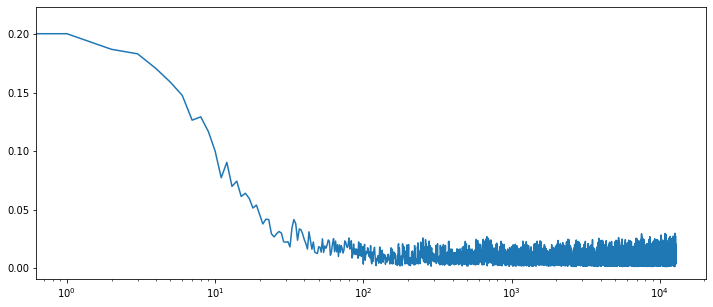

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize = (12, 5))
g = sns.lineplot(x = range(len(losses)), y = losses)
# as we may have a lot of epochs we log scale the x-axis
g.set_xscale("log")

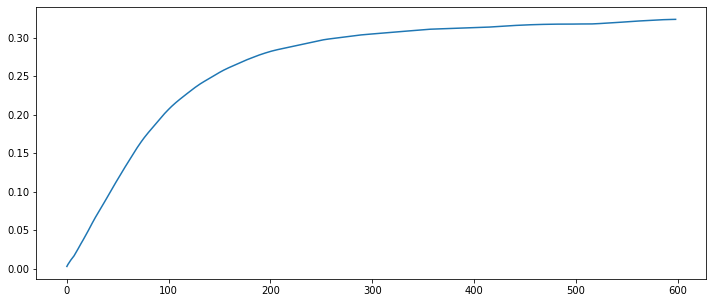

In [13]:
plt.figure(figsize = (12, 5))
plt.plot(ma_rewads)

As we see the loss is decreasing over time while average reward is increasing which indicates that the model is learning how to make better recommendations over time.